---
# Classification - Loan Eligibility Prediction
---

## Context: 
---

Credit risk is the risk of loss resulting from the failure by a borrower to repay the principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

**Loading Data**

In [4]:
data = pd.read_csv("Loan_approval.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [6]:
data.Loan_ID.nunique()

614

**Observations:**
- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## Exploratory Data Analysis and Data Preprocessing

**Dropping Loan_ID column**

In [7]:
data.drop(columns=['Loan_ID'], inplace = True)

**Summary Statistics for numerical columns**

In [8]:
#Creating a list of numerical columns
num_cols = num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

#printing summary statistics

data[num_cols].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


**Observations:**

* The mean applicant income is around $5403.46

* The minimum value for applicant income is $150 which is very small and could be an outlier since it is very far from both the mean and the median. 

* There are a good number of co applicants with no income, as can be observed by thet fact that the 25% quantile of coapplicants have an income of 0. 

## Feature Engineering

In [9]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [10]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [11]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

**Checking the distribution and outliers for each column in the data**

LoanAmount
Skew : 2.68


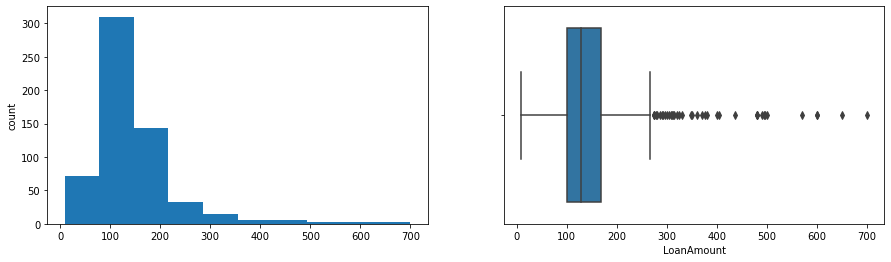

total_income
Skew : 5.63


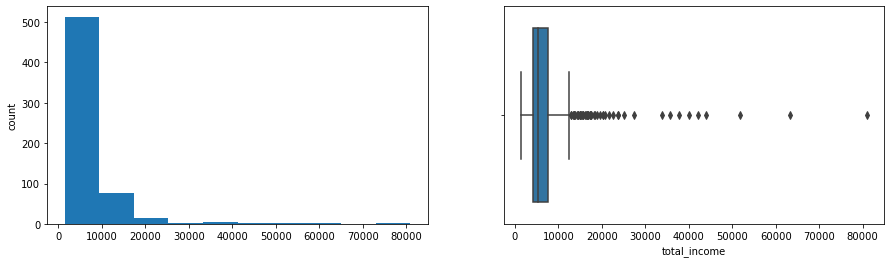

In [12]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10,000K dollars.

Now, let's check the percentage of observations in each category for all the categorical variables.

### Checking percentage of each category for categorical variables

In [13]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True))
    print('*'*40)                #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**

* The vast majority of applicants are male (81%). 

* 65% of applicants are married, and 57% of them have no dependents

* 78% of the applicants are graduates

* 85% of the applicants are self employed

* 84% of the applicants have credit histories that meet the required guidelines

* The property area among the applicants is roughly evenly split across semiurban, urban, and rural, with semi-urban having a slightly higher portion (37.9%)

## Imputing missing values

In [14]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [15]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**Checking for null values**

In [16]:
data.isnull().sum()

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
total_income        0
dtype: int64

**Finally, we need to encode our loan status column to make it eligible for modeling**

In [17]:
data.replace({"Loan_Status":{'N':0,'Y':1}},inplace=True) # label encoding

**We are now done with data preprocessing**

## Bivariate Analysis

Let's check the relationship of loan amount with the total income

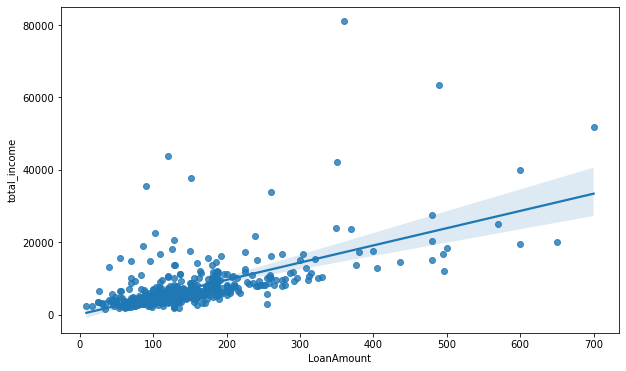

In [18]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

**Observations:**
- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relatioship of total income with loan status

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

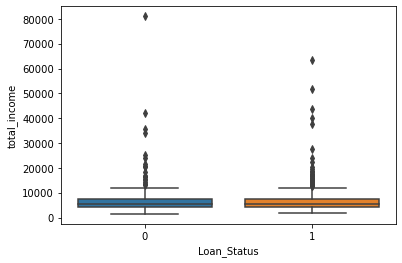

In [19]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

**Observations:**
- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

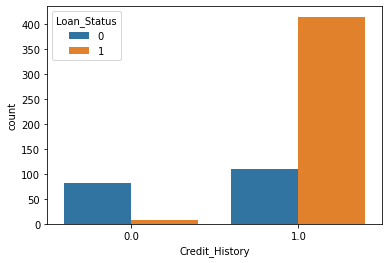

In [20]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

**Observations**

- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

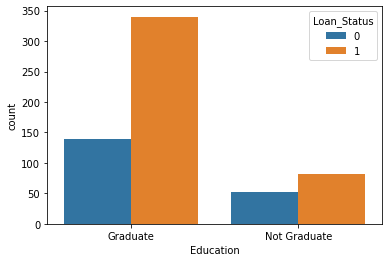

In [21]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

**Observations:**
- We can see that graduate customers are more likely to get loans.


Let's check if property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

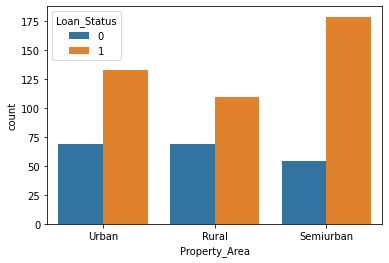

In [22]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

**Observations:**

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

In [23]:
#Separating target variable and other variables

X= data.drop(columns = ['Loan_Status'])
Y= data.Loan_Status

In [24]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [25]:
#Splitting the data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Positives?
* In the context of Loan eligibility a False positive means that model incorrectly approves loan for some one who shouldn't be eligible which could lead to financial loss for the customer.One way to minimize precision is by optimizing the models precision.By increasing the precision you can decrease the false positives.However it is important to strike a balance between precision and recall to ensure that the model is not overly conservative and rejects a significant number of eligible applicants(False Negatives).We need to strike the right balance and improve the overall perormance in the loan eligibility prediction.


Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [26]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Logistic Regression

In [27]:
#define logistic regression model 
log_reg= LogisticRegression(random_state = 1)

#fit the model
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=1)

**Let's check the coefficient of each dependent variable in the data**

In [28]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.160963
Property_Area_Semiurban    0.682570
Dependents_3+              0.405391
Married_Yes                0.346768
Dependents_2               0.146093
total_income              -0.000012
LoanAmount                -0.000442
Property_Area_Urban       -0.004817
Loan_Amount_Term          -0.061630
Self_Employed_Yes         -0.113987
Gender_Male               -0.200656
Dependents_1              -0.246792
Education_Not Graduate    -0.368435
dtype: float64

**Let's now find the odds calculated from the logistic regression model coefficients**

In [29]:
 #finding the odds
odds = np.exp(log_reg.coef_[0])
#adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,23.593299
Property_Area_Semiurban,1.978958
Dependents_3+,1.499889
Married_Yes,1.414489
Dependents_2,1.157304
total_income,0.999988
LoanAmount,0.999558
Property_Area_Urban,0.995194
Loan_Amount_Term,0.940231
Self_Employed_Yes,0.892269


The odds ratios associated with class 0 (e.g., odds = np.exp(log_reg.coef_[0])) represent the multiplicative change in the odds of being "Not Eligible" for a one-unit
increase in the corresponding feature.If the resulting odds ratio is greater than 1, it indicates that for every one-unit increase in the Propert area, the odds of being "Not Eligible" increase by that factor. For example, if the odds ratio is 1.97, it means that a one-unit increase in the loan amount  almost doubles the odds of being "Not Eligible."

On the other hand, if the odds ratio is less than 1, it indicates a decrease in the odds of being "Not Eligible" for a one-unit increase in the loan amount. For example, if the odds ratio is 0.69, it means that a one-unit increase in the loan amount reduces the odds of being "Not Eligible" by half.

**Observations:**

* The odds of an applicant's loan application being approved is around 20 times higher for a person who meets the loan approval requirements compared to someone who doesn't

* The odds of an applicant's loan application being approved is over double if he is married compared to someone who is not. 



**Now, let's check the performance of the model on the training set**

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



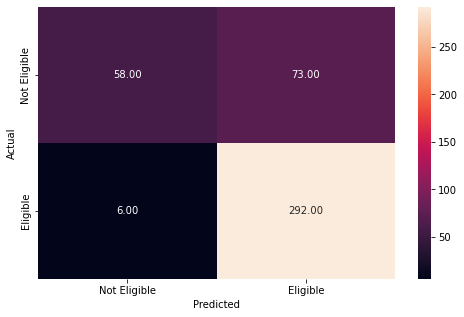

In [30]:
#predict on the training data 
y_pred_train = log_reg.predict(X_train) #Write your code here

# Checking performance on the training data
metrics_score(y_train, y_pred_train)

In [31]:
from sklearn.metrics import roc_auc_score
AUROC = roc_auc_score(y_train, y_pred_train)
AUROC

0.711306931707567

**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is eligible and the customer is actually eligible
- **False Negative**: Predicting the customer is  not eligible but the customer is actually eligible
- **True Negative**: Predicting the customer is not  eligible and the customer is actually not eligible
- **False Positive**: Predicting the customer is eligible but the customer is actually not  eligible

**Observations:**

* We see around 82% accuracy on our training set.

* The recall score is only 44% for class 0 which is low, considering we want to get a strong recall value for our specific problem. Thus, this model will not perform well for us. 

**Precision-Recall curve for Logistic Regression**

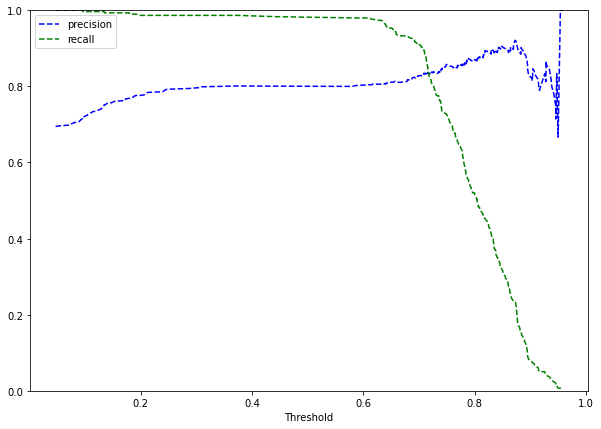

In [32]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plotting values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

**Observations:**
- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [33]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7168397981410463


- The threshold of 0.72 would give a balanced precision and recall.
- Higher the treshhold the FP would decrease , but it might be at the cost of increase in FN.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false negatives and be more conservative while approving loans then we can choose for the precision to be higher.
- Let's choose the threshholdto be 0.75 for the current scenario, since we have mentioned that the company wants to optimize precision.


**So let's compare the performance of the model on the training and testing sets after changing the threshold**

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       131
           1       0.86      0.72      0.79       298

    accuracy                           0.72       429
   macro avg       0.70      0.73      0.70       429
weighted avg       0.76      0.72      0.73       429



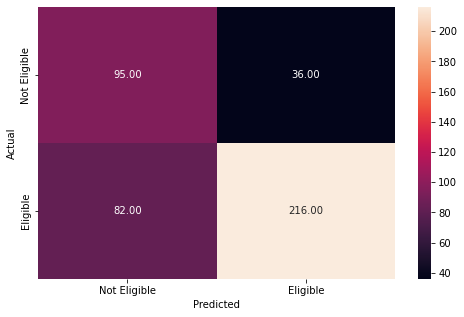

In [37]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.54      0.64      0.59        61
           1       0.81      0.73      0.77       124

    accuracy                           0.70       185
   macro avg       0.67      0.69      0.68       185
weighted avg       0.72      0.70      0.71       185



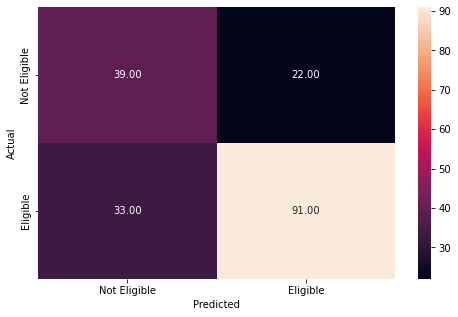

In [40]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)


In [43]:
AUROC = roc_auc_score(y_test, y_pred_test[:,1])
AUROC

0.7485457429931254

**Observations:**

* We can see that we got AUROC as 0.74, and we could optimise both preciison and recall
* Similar performance on both the training data and the test data

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), we split the train set into new train and validation set (30 times)
- We scale the training data and validation data
- We take the average of the error on these train and the validation sets for each K
- We plot the average train vs the validation set error for all Ks 
- Finally, we choose a suitable K from the plot where the two errors are comparable

In [33]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.2856589147286821],
 2: [0.11409135082604469, 0.3453488372093023],
 3: [0.15889212827988336, 0.24612403100775188],
 4: [0.1634596695821186, 0.2682170542635659],
 5: [0.18513119533527694, 0.21821705426356588],
 6: [0.1862973760932945, 0.23255813953488372],
 7: [0.19591836734693882, 0.20348837209302334],
 8: [0.19426627793974735, 0.22054263565891483],
 9: [0.20038872691933915, 0.21046511627906986],
 10: [0.1936831875607386, 0.22790697674418595],
 11: [0.2013605442176871, 0.21589147286821703],
 12: [0.19659863945578232, 0.21240310077519378],
 13: [0.203692905733722, 0.20930232558139542],
 14: [0.192614188532556, 0.2220930232558139],
 15: [0.19815354713313899, 0.21395348837209308],
 16: [0.1932944606413994, 0.210077519379845],
 17: [0.20058309037900873, 0.21007751937984492],
 18: [0.19708454810495632, 0.21124031007751945],
 19: [0.20068027210884357, 0.20813953488372097],
 20: [0.19757045675413026, 0.20891472868217056]}

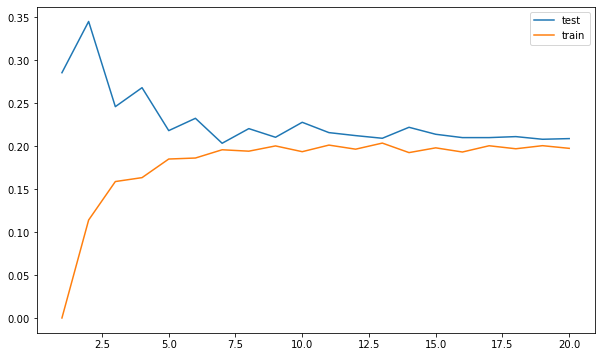

In [34]:
# Extracting the train and the test error for each k in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error 
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

**Observations:**
- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [35]:
# scaling the data
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [36]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



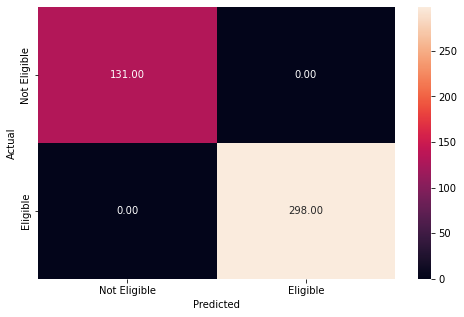

In [37]:
#predicting on train data
y_pred_train_knn = knn.predict(X_train_scaled)# write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:**

* The performance on the training set is very strong, as it predicts perfectly who is eligible and who isn't. The precission, recall, and and accuracy are all optimal at 100%. 

              precision    recall  f1-score   support

           0       0.61      0.31      0.41        61
           1       0.73      0.90      0.81       124

    accuracy                           0.71       185
   macro avg       0.67      0.61      0.61       185
weighted avg       0.69      0.71      0.68       185



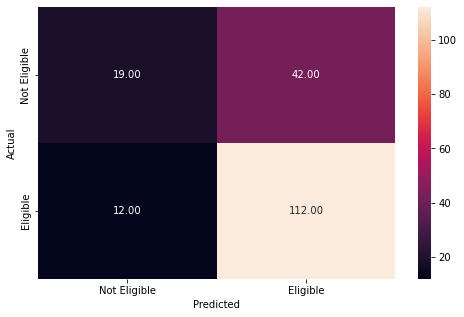

In [38]:
#predict on test data
y_pred_test_knn = knn.predict(X_test_scaled)# Write your code here

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:**

* We see a weak performance on the scaled testing data, as the recall score is only 0.31 for the 0. There were 42 people that our Knn model predicted to be eligible who are actually not eligible, which is concerning given that we want to minimize this value as much as possible. 

## Conclusion

* Using multiple models, EDA, and visualization, we were able to identify the key factors that are involved with whether or not a loan application will be accepted, with the biggest one being credit history. 

* Our Logistic regression model gave thet highest recall score which is the measure that we wanted to maximize, since we don't want to grant loans to applicants who are unable to repay them, since it would hurt the company.